In [1]:
# 04_hierarchical_demo.ipynb (Python Code exportiert als Skript zur Vorlage)

import matplotlib.pyplot as plt
from shapely.geometry import LineString
from planners.hierarchical_planner import HierarchicalPlanner  # korrekt benannt als HierarchicalPlanner bei dir?
from planners.lazy_prm import LazyPRM
from planners.basic_prm import BasicPRM
from planners.visibility_prm import VisibilityPRM
from utils.collision_checker import CollisionChecker
from utils.hierarchical_visualize import visualize_hierarchical_planning
from environment import get_all_scenes

scenes = get_all_scenes()
# Suche nach der U-Shape Szene in der Liste
scene_data = next((data for name, data in scenes if name == "Corridor"), None)
if scene_data:
    scene, limits, (start, goal) = scene_data
else:
    raise ValueError("Shape Szene nicht gefunden")


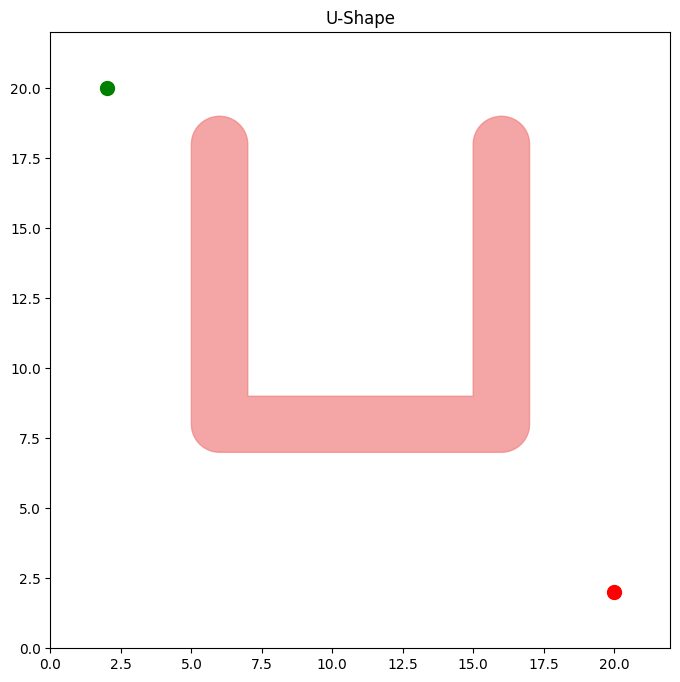

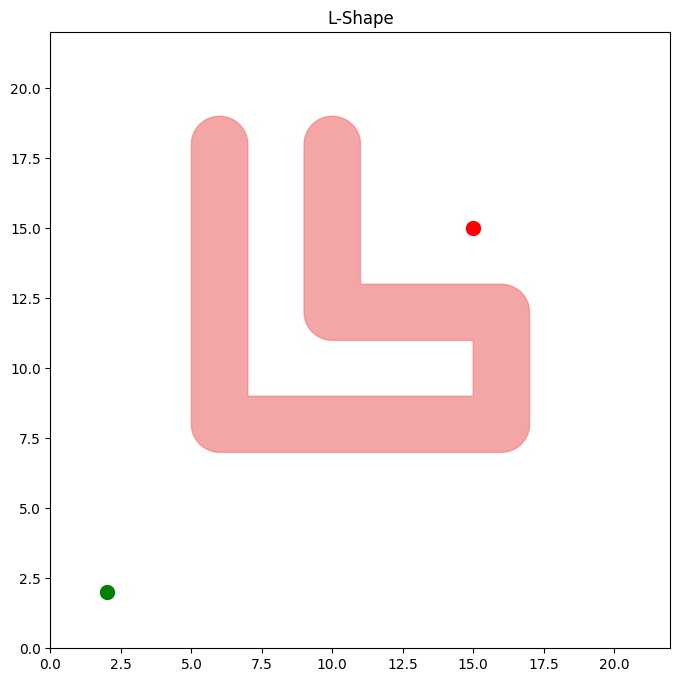

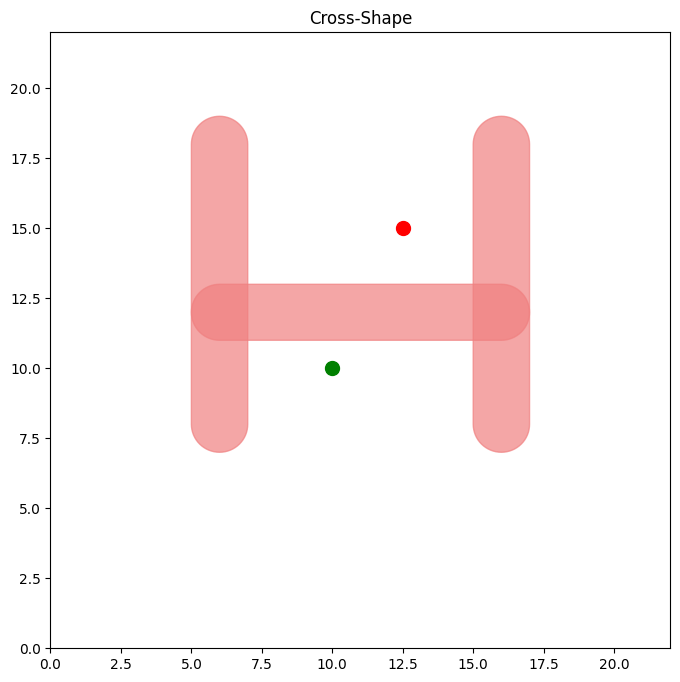

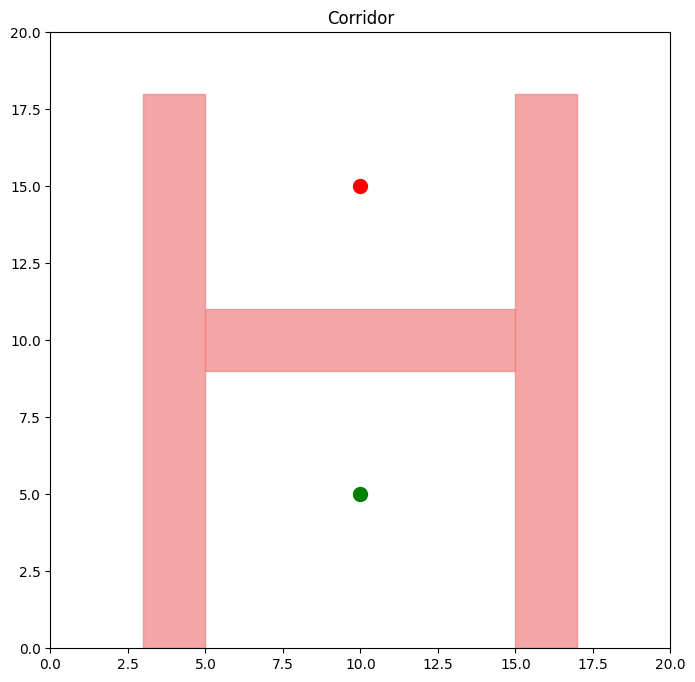

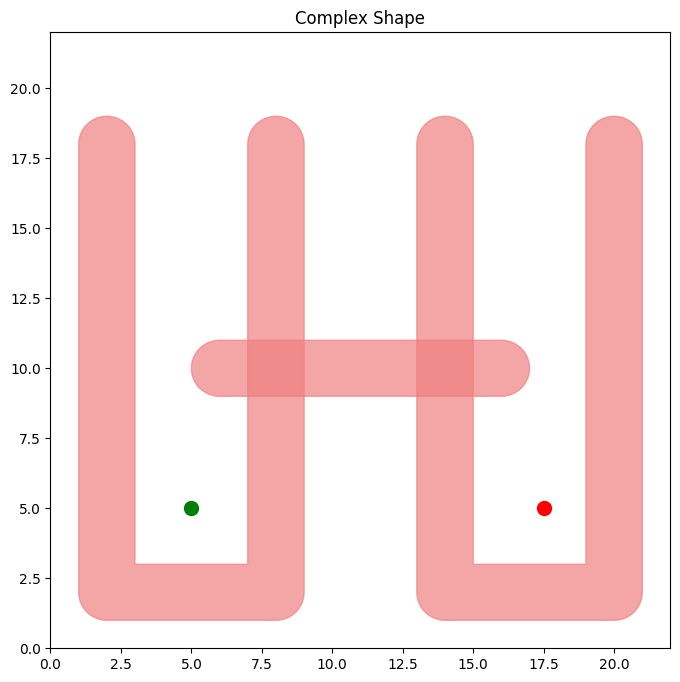

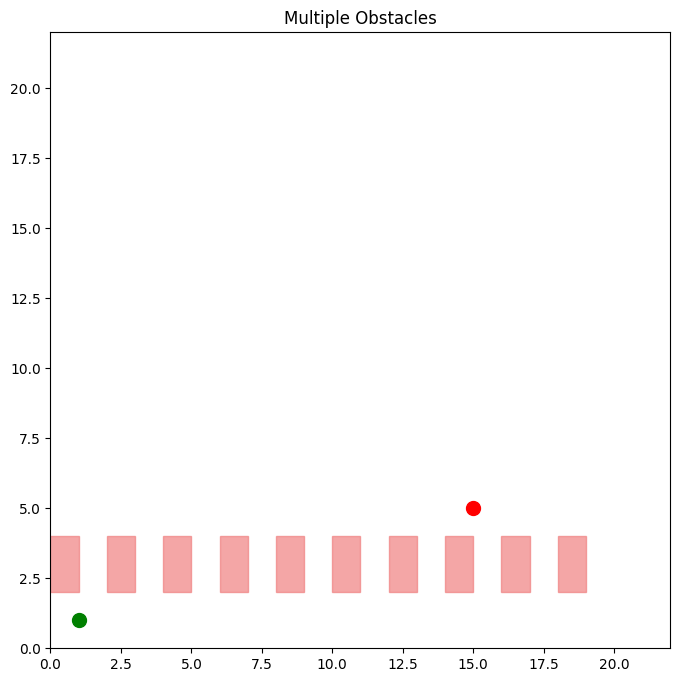

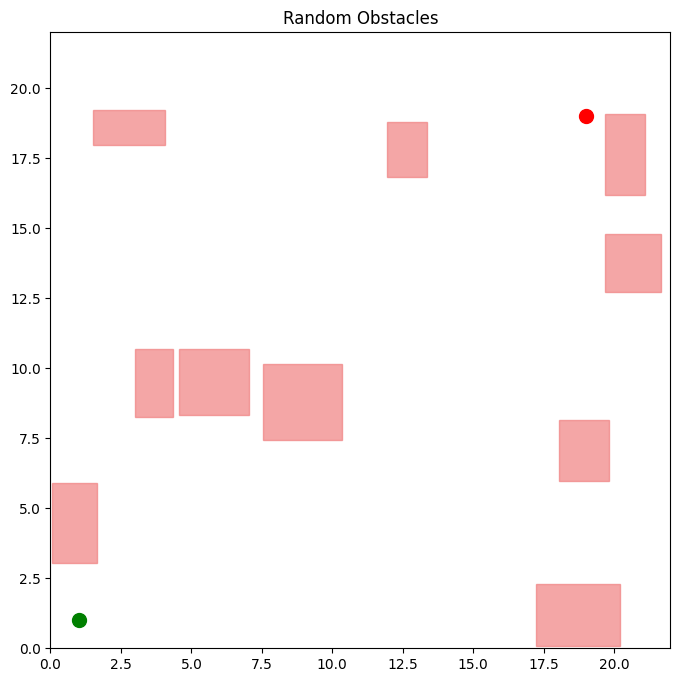

In [2]:
# Plotte alle Szenen zur Überprüfung
for name, (scene, limits, (start, goal)) in scenes:
    fig, ax = plt.subplots(figsize=(8, 8))
    for shape in scene.values():
        xs, ys = shape.exterior.xy if hasattr(shape, 'exterior') else shape.xy
        ax.fill(xs, ys, color='lightcoral', alpha=0.7)
    # Zeichne Start- und Zielpunkte
    ax.plot(start[0], start[1], 'go', markersize=10)
    ax.plot(goal[0], goal[1], 'ro', markersize=10)
    ax.set_title(name)
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    plt.show()

In [3]:
# --- Konfiguration für den globalen Planer (VisibilityPRM) ---
config_high = {
    "ntry": 100,  # Anzahl der Versuche für die Roadmap
    "kNearest": 10,  # Anzahl der nächsten Nachbarn
    "maxIterations": 20  # Maximale Iterationen für den globalen Planer
}

config_low = {
    "initialRoadmapSize": 100,
    "updateRoadmapSize": 20,
    "kNearest": 8,
    "maxIterations": 10
}

config_low_basic = {
    "numNodes": 100,
    "radius": 3.0
}


In [4]:
# check all scenes and safe them in a list
scenes = get_all_scenes()
# check all scenes for collision checking
for name, (scene, limits, (start, goal)) in scenes:
    print(f"Scene: {name}, Limits: {limits}, Start: {start}, Goal: {goal}")


Scene: U-Shape, Limits: ((0, 22), (0, 22)), Start: (2.0, 20.0), Goal: (20.0, 2.0)
Scene: L-Shape, Limits: ((0, 22), (0, 22)), Start: (2.0, 2.0), Goal: (15.0, 15.0)
Scene: Cross-Shape, Limits: ((0, 22), (0, 22)), Start: (10, 10.0), Goal: (12.5, 15.0)
Scene: Corridor, Limits: ((0, 20), (0, 20)), Start: (10.0, 5.0), Goal: (10.0, 15.0)
Scene: Complex Shape, Limits: ((0, 22), (0, 22)), Start: (5.0, 5.0), Goal: (17.5, 5.0)
Scene: Multiple Obstacles, Limits: ((0, 22), (0, 22)), Start: (1.0, 1.0), Goal: (15.0, 5.0)
Scene: Random Obstacles, Limits: ((0, 22), (0, 22)), Start: (1.0, 1.0), Goal: (19.0, 19.0)


In [5]:
# --- Planer aufsetzen ---
scene_data = next((data for name, data in scenes if name == "Complex Shape"), None)
if scene_data:
    scene, limits, (start, goal) = scene_data
else:
    raise ValueError("Shape Szene nicht gefunden")
collision_checker = CollisionChecker(scene, limits)
start = [[5, 5]]
goal = [[17.5, 5]]
hier_planner = HierarchicalPlanner(
    scene=scene,
    limits=limits,
    GlobalPlannerClass=VisibilityPRM,
    LocalPlannerClass=LazyPRM,
    config_global=config_high,
    config_local=config_low
)


Globaler Pfad: ['start', 51, 0, 27, 12, 24, 'goal']
Koordinaten des globalen Pfads: [[5, 5], array([4.03722543, 7.28530494]), array([ 6.08717785, 21.05241739]), array([19.40931614, 21.56617566]), array([16.56478344, 15.93824491]), array([17.6459821 ,  6.33525954]), [17.5, 5]]
Segment 0: [5, 5] → [4.03722543 7.28530494]
→ Lokaler Planner für Segment 0: [5, 5] → [4.03722543 7.28530494]
   Lokale Begrenzung (geclipped): ((np.float64(2.0387833753652154), np.float64(6.998442049838621)), (np.float64(3.662823131795974), np.float64(8.622481806269379)))
Segment 1: [4.03722543 7.28530494] → [ 6.08717785 21.05241739]
→ Lokaler Planner für Segment 1: [4.03722543 7.28530494] → [ 6.08717785 21.05241739]
   Lokale Begrenzung (geclipped): ((0, np.float64(13.062201637164042)), (np.float64(6.168861164894373), 22))
Segment 2: [ 6.08717785 21.05241739] → [19.40931614 21.56617566]
→ Lokaler Planner für Segment 2: [ 6.08717785 21.05241739] → [19.40931614 21.56617566]
   Lokale Begrenzung (geclipped): ((np.f

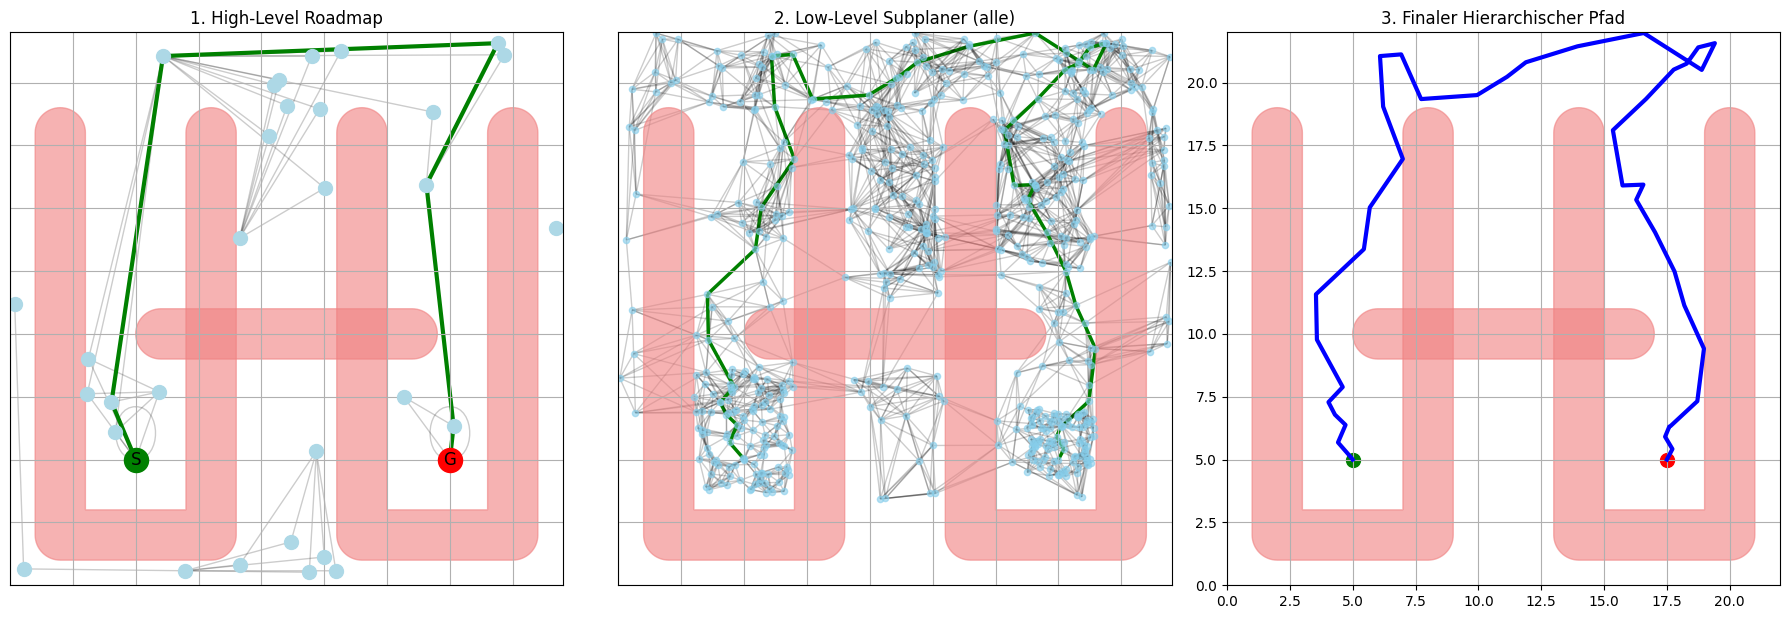

In [6]:
# --- Pfadplanung ---
path = hier_planner.plan_path(start, goal)
if not path:
    print("❌ Kein Pfad gefunden.")
else:
    print("✅ Pfad gefunden mit", len(path), "Punkten")

    # Korrekte Reihenfolge der Initialisierung für die Visualisierung
    hier_planner.solution_path = path  # Statt final_path
    hier_planner.graph = hier_planner.global_planner.graph  # Verwende direkt den globalen Planer-Graph

    collision_checker = CollisionChecker(hier_planner.scene, hier_planner.limits)
    visualize_hierarchical_planning(hier_planner, collision_checker, hier_planner.config_local)



🔄 Verarbeite Szene: U-Shape
Globaler Pfad: ['start', 2, 42, 'goal']
Koordinaten des globalen Pfads: [[2.0, 20.0], array([3.2736228 , 8.39914106]), array([16.72565886,  0.66011609]), [20.0, 2.0]]
Segment 0: [2.0, 20.0] → [3.2736228  8.39914106]
→ Lokaler Planner für Segment 0: [2.0, 20.0] → [3.2736228  8.39914106]
   Lokale Begrenzung (geclipped): ((0, np.float64(10.63681139946602)), (np.float64(6.19957053243029), 22))
Segment 1: [3.2736228  8.39914106] → [16.72565886  0.66011609]
→ Lokaler Planner für Segment 1: [3.2736228  8.39914106] → [16.72565886  0.66011609]
   Lokale Begrenzung (geclipped): ((np.float64(1.9996408281199898), np.float64(17.99964082811999)), (0, np.float64(12.529628577830408)))
Segment 2: [16.72565886  0.66011609] → [20.0, 2.0]
→ Lokaler Planner für Segment 2: [16.72565886  0.66011609] → [20.0, 2.0]
   Lokale Begrenzung (geclipped): ((np.float64(14.824948875433112), np.float64(21.900709981874837)), (0, np.float64(4.867938598620981)))
✅ Pfad gefunden in Szene: U-Sha

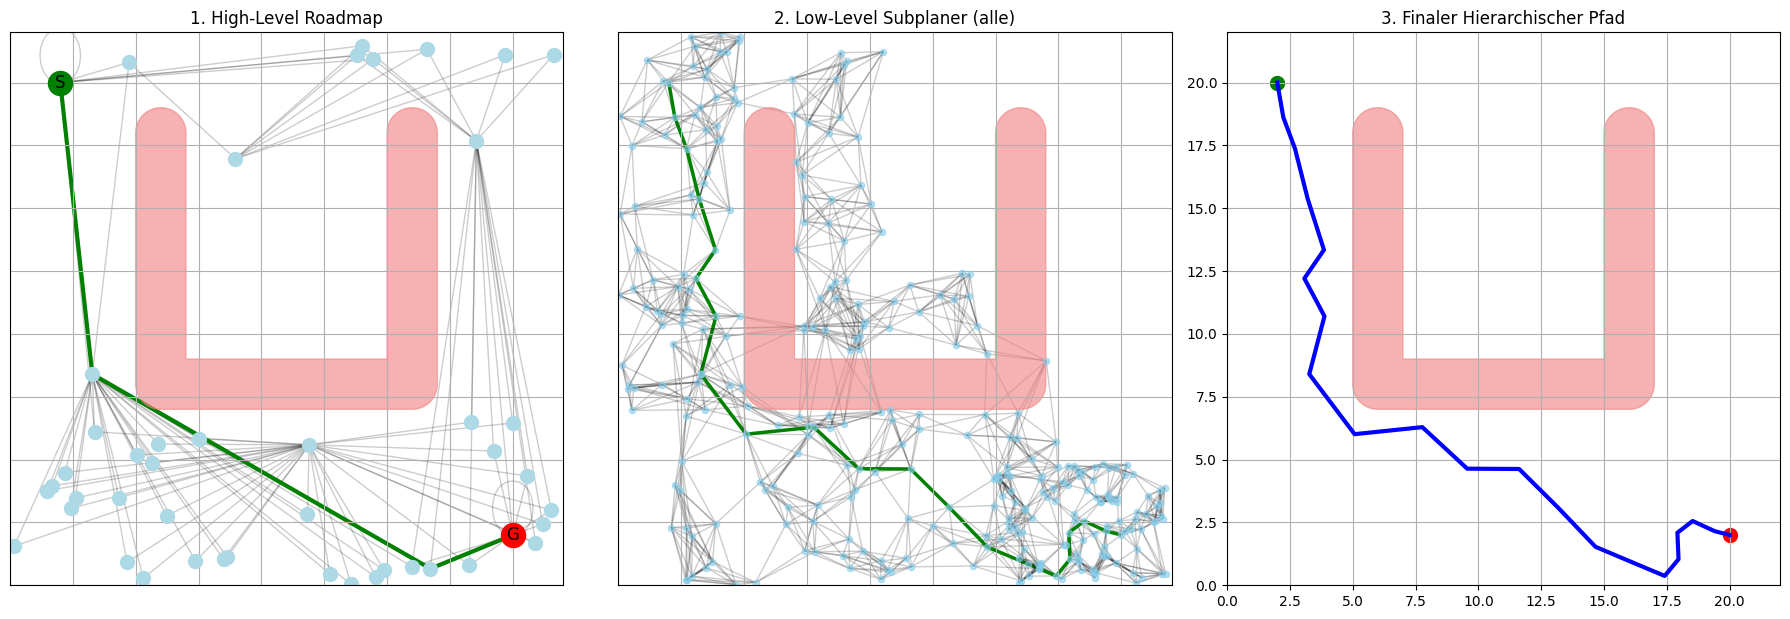


🔄 Verarbeite Szene: L-Shape
Globaler Pfad: ['start', 105, 0, 65, 'goal']
Koordinaten des globalen Pfads: [[2.0, 2.0], array([2.36276942, 2.90465677]), array([14.6587291 ,  2.81647869]), array([21.04477889, 15.6435814 ]), [15.0, 15.0]]
Segment 0: [2.0, 2.0] → [2.36276942 2.90465677]
→ Lokaler Planner für Segment 0: [2.0, 2.0] → [2.36276942 2.90465677]
   Lokale Begrenzung (geclipped): ((np.float64(1.2067024448051866), np.float64(3.156066976781352)), (np.float64(1.4776461175988398), np.float64(3.4270106495750046)))
Segment 1: [2.36276942 2.90465677] → [14.6587291   2.81647869]
→ Lokaler Planner für Segment 1: [2.36276942 2.90465677] → [14.6587291   2.81647869]
   Lokale Begrenzung (geclipped): ((np.float64(0.5107492629982513), np.float64(16.510749262998253)), (0, np.float64(10.860567728255747)))
Segment 2: [14.6587291   2.81647869] → [21.04477889 15.6435814 ]
→ Lokaler Planner für Segment 2: [14.6587291   2.81647869] → [21.04477889 15.6435814 ]
   Lokale Begrenzung (geclipped): ((np.flo

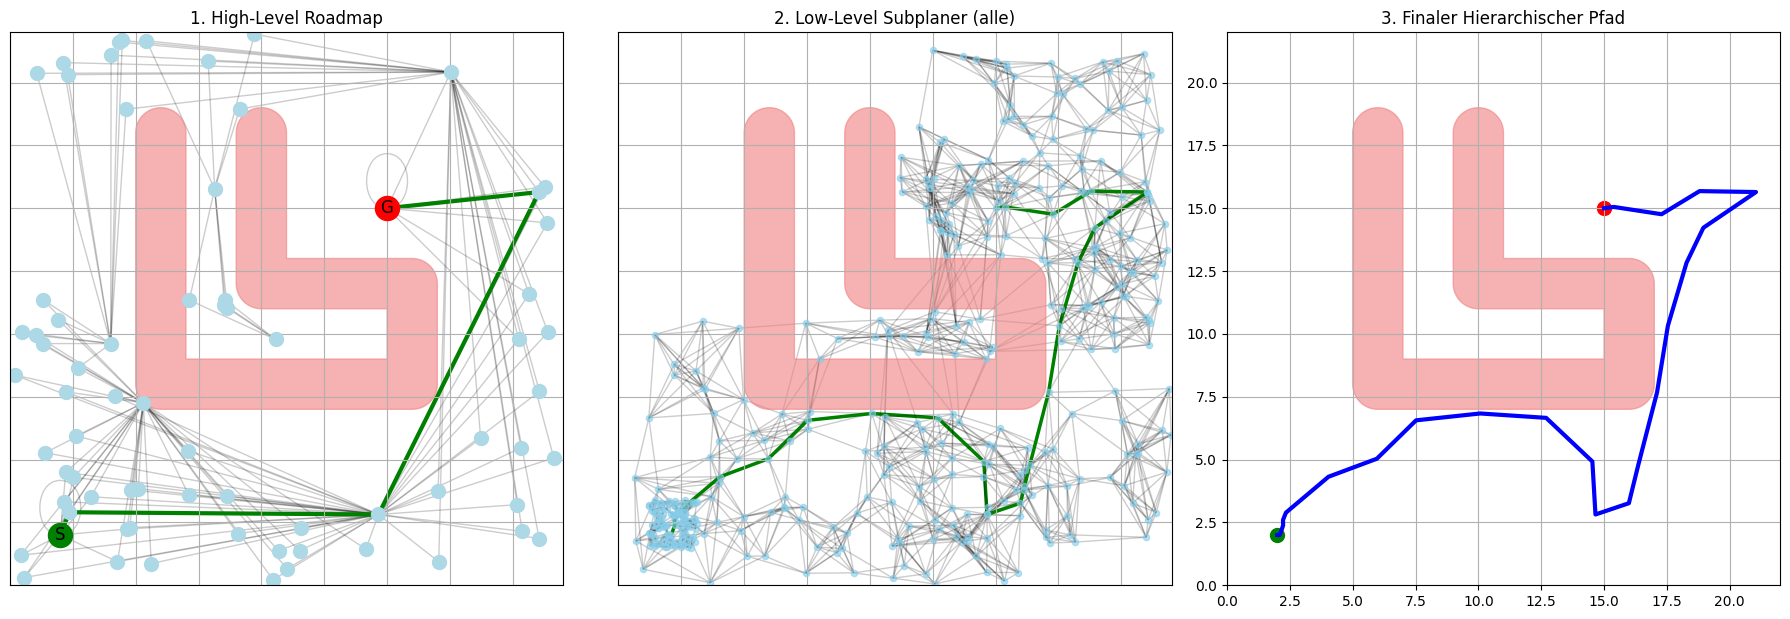


🔄 Verarbeite Szene: Cross-Shape
Globaler Pfad: ['start', 18, 2, 105, 'goal']
Koordinaten des globalen Pfads: [[10, 10.0], array([15.63423569,  4.42142385]), array([20.38698659, 15.42294162]), array([13.85177121, 21.5132524 ]), [12.5, 15.0]]
Segment 0: [10, 10.0] → [15.63423569  4.42142385]
→ Lokaler Planner für Segment 0: [10, 10.0] → [15.63423569  4.42142385]
   Lokale Begrenzung (geclipped): ((np.float64(4.888364875428667), np.float64(20.74587080980445)), (0, np.float64(15.139464892340813)))
Segment 1: [15.63423569  4.42142385] → [20.38698659 15.42294162]
→ Lokaler Planner für Segment 1: [15.63423569  4.42142385] → [20.38698659 15.42294162]
   Lokale Begrenzung (geclipped): ((np.float64(10.010611139623894), 22), (np.float64(1.9221827345818525), np.float64(17.922182734581853)))
Segment 2: [20.38698659 15.42294162] → [13.85177121 21.5132524 ]
→ Lokaler Planner für Segment 2: [20.38698659 15.42294162] → [13.85177121 21.5132524 ]
   Lokale Begrenzung (geclipped): ((np.float64(9.11937890

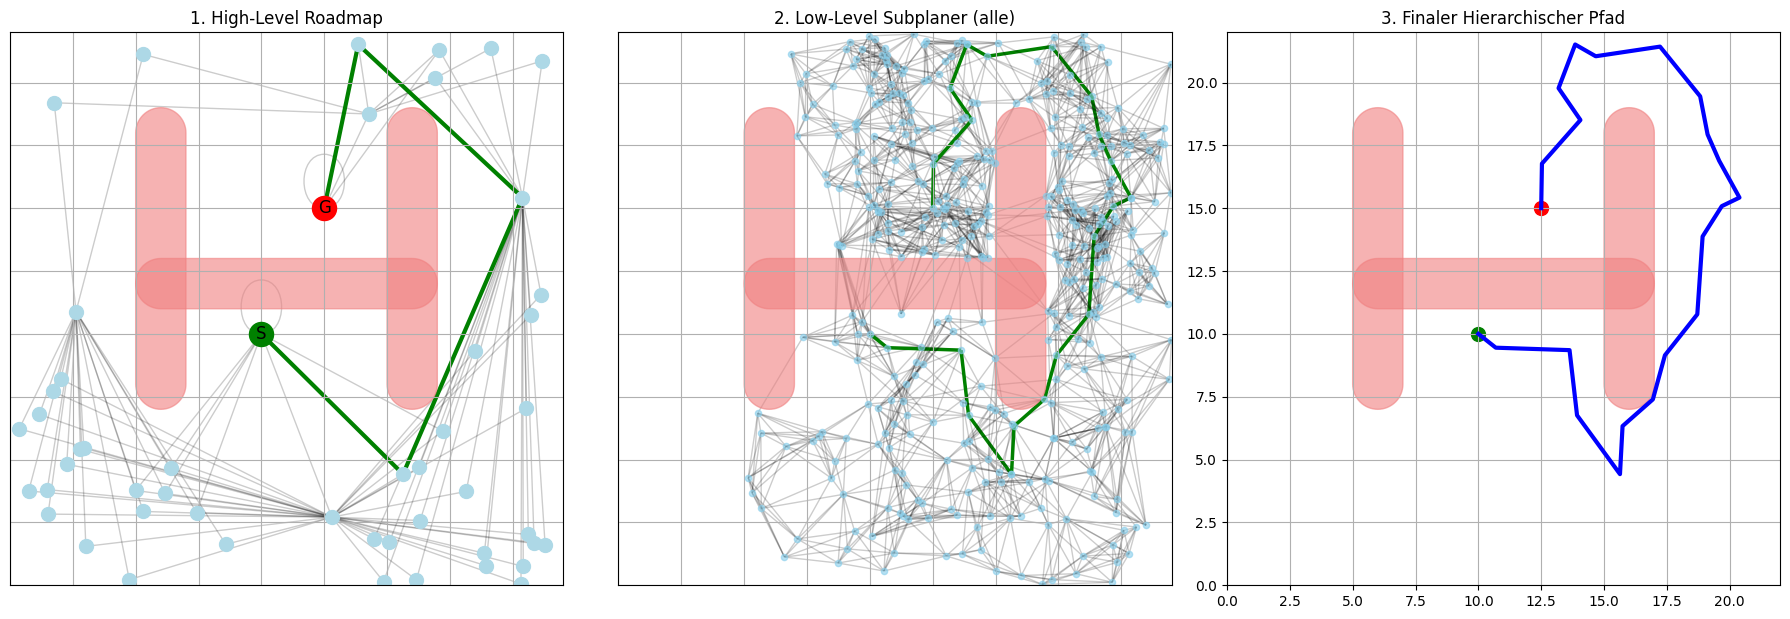


🔄 Verarbeite Szene: Corridor
Kein Pfad im Sichtbarkeitsgraph gefunden.
❌ Kein Pfad gefunden in Szene: Corridor

🔄 Verarbeite Szene: Complex Shape
Globaler Pfad: ['start', 7, 17, 0, 148, 'goal']
Koordinaten des globalen Pfads: [[5.0, 5.0], array([3.24181662, 4.49188753]), array([ 3.60952797, 18.2058926 ]), array([13.99561375, 21.63854923]), array([18.58591406,  7.10949517]), [17.5, 5.0]]
Segment 0: [5.0, 5.0] → [3.24181662 4.49188753]
→ Lokaler Planner für Segment 0: [5.0, 5.0] → [3.24181662 4.49188753]
   Lokale Begrenzung (geclipped): ((np.float64(2.2907752406567026), np.float64(5.951041383873545)), (np.float64(2.9158106954348453), np.float64(6.576076838651688)))
Segment 1: [3.24181662 4.49188753] → [ 3.60952797 18.2058926 ]
→ Lokaler Planner für Segment 1: [3.24181662 4.49188753] → [ 3.60952797 18.2058926 ]
   Lokale Begrenzung (geclipped): ((0, np.float64(11.425672298681407)), (np.float64(3.348890068571542), np.float64(19.348890068571542)))
Segment 2: [ 3.60952797 18.2058926 ] → [1

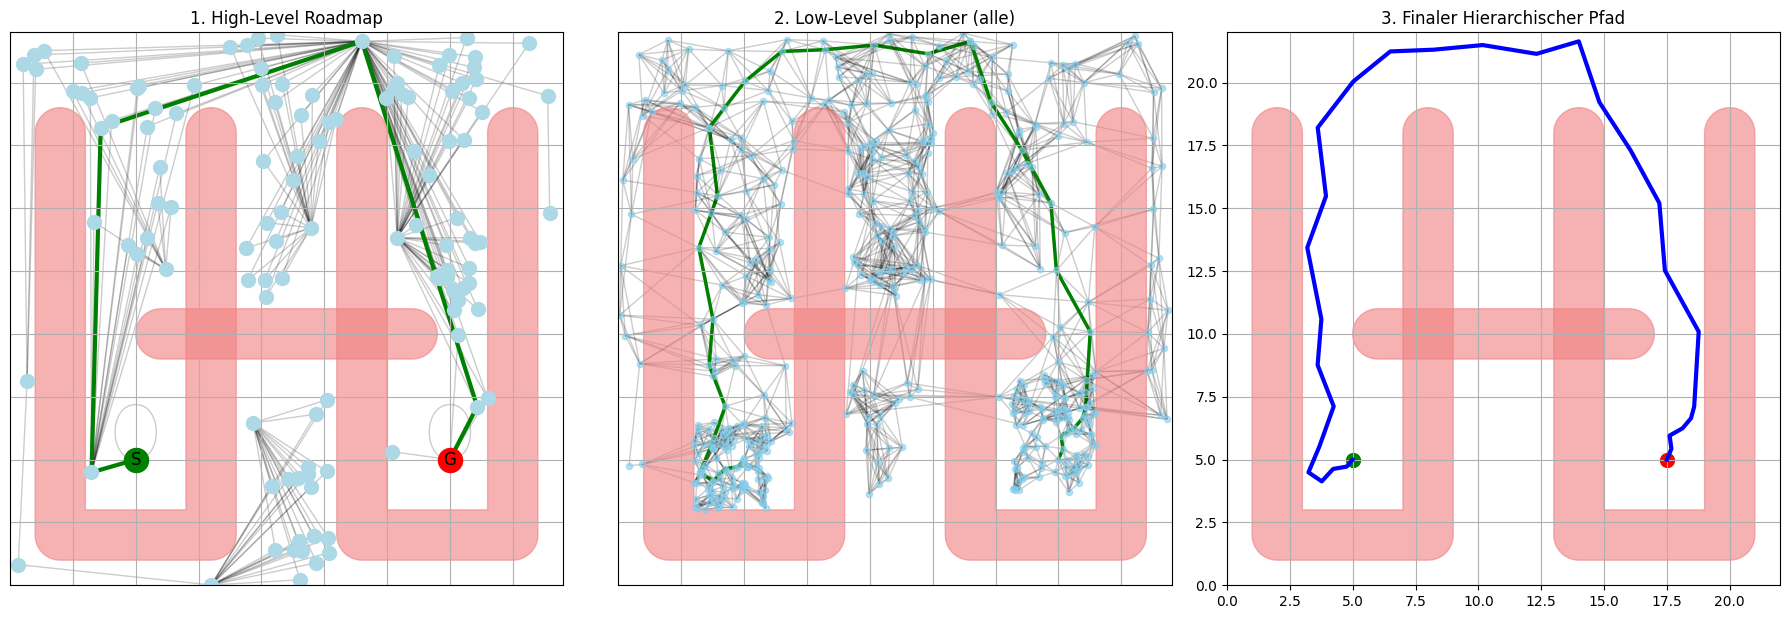


🔄 Verarbeite Szene: Multiple Obstacles
Globaler Pfad: ['start', 204, 0, 180, 'goal']
Koordinaten des globalen Pfads: [[1.0, 1.0], array([0.97564588, 1.89915743]), array([ 6.94441481, 19.51394569]), array([13.02335194,  5.47490558]), [15.0, 5.0]]
Segment 0: [1.0, 1.0] → [0.97564588 1.89915743]
→ Lokaler Planner für Segment 0: [1.0, 1.0] → [0.97564588 1.89915743]
   Lokale Begrenzung (geclipped): ((np.float64(0.0883357450347858), np.float64(1.8873101331319582)), (np.float64(0.5500915223646606), np.float64(2.349065910461833)))
Segment 1: [0.97564588 1.89915743] → [ 6.94441481 19.51394569]
→ Lokaler Planner für Segment 1: [0.97564588 1.89915743] → [ 6.94441481 19.51394569]
   Lokale Begrenzung (geclipped): ((0, np.float64(11.960030342894266)), (np.float64(2.7065515593800438), np.float64(18.706551559380046)))
Segment 2: [ 6.94441481 19.51394569] → [13.02335194  5.47490558]
→ Lokaler Planner für Segment 2: [ 6.94441481 19.51394569] → [13.02335194  5.47490558]
   Lokale Begrenzung (geclipped

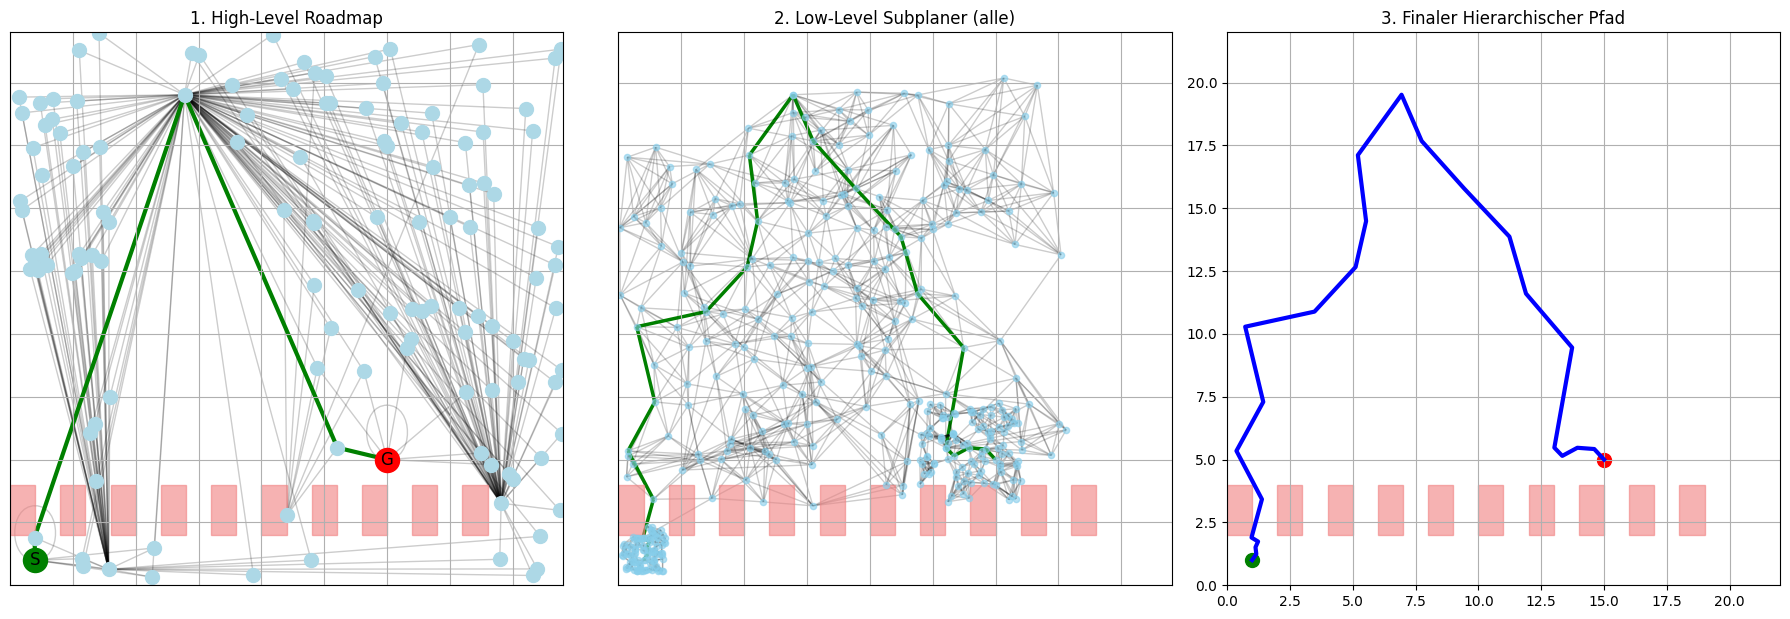


🔄 Verarbeite Szene: Random Obstacles
Globaler Pfad: ['start', 184, 0, 8, 'goal']
Koordinaten des globalen Pfads: [[1.0, 1.0], array([1.53270038, 1.5705154 ]), array([ 9.63287645, 13.33358892]), array([21.30067499, 18.84976956]), [19.0, 19.0]]
Segment 0: [1.0, 1.0] → [1.53270038 1.5705154 ]
→ Lokaler Planner für Segment 0: [1.0, 1.0] → [1.53270038 1.5705154 ]
   Lokale Begrenzung (geclipped): ((np.float64(0.4858006944885238), np.float64(2.046899683416744)), (np.float64(0.5047082051198639), np.float64(2.0658071940480838)))
Segment 1: [1.53270038 1.5705154 ] → [ 9.63287645 13.33358892]
→ Lokaler Planner für Segment 1: [1.53270038 1.5705154 ] → [ 9.63287645 13.33358892]
   Lokale Begrenzung (geclipped): ((0, np.float64(13.582788411559868)), (0, np.float64(15.452052158015933)))
Segment 2: [ 9.63287645 13.33358892] → [21.30067499 18.84976956]
→ Lokaler Planner für Segment 2: [ 9.63287645 13.33358892] → [21.30067499 18.84976956]
   Lokale Begrenzung (geclipped): ((np.float64(7.46677571875889

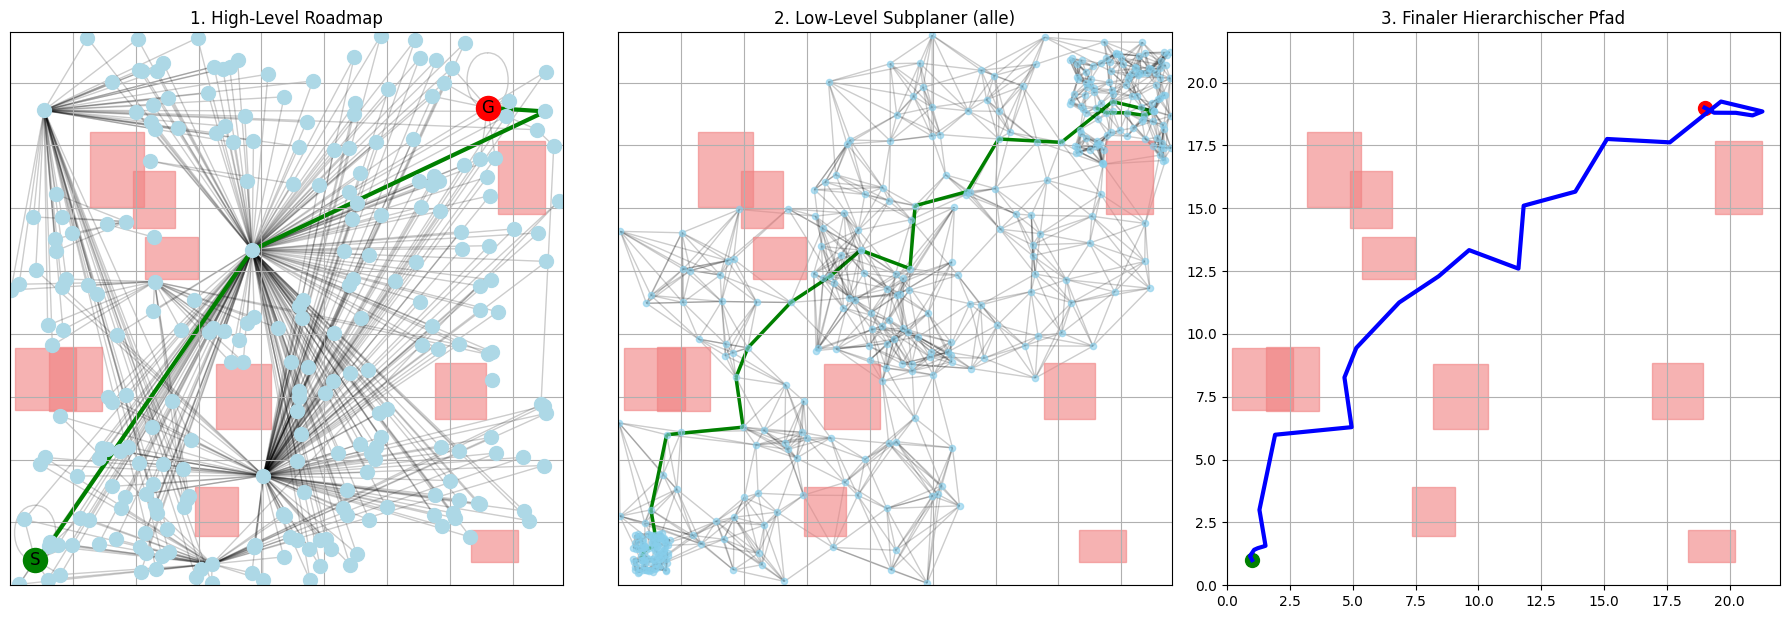

In [7]:
# --- Jede Szene durchlaufen ---
for name, (scene, limits, (start_tuple, goal_tuple)) in scenes:
    print(f"\n🔄 Verarbeite Szene: {name}")

    # Start- und Zielposition ins passende Format bringen
    start = [list(start_tuple)]
    goal = [list(goal_tuple)]

    # Kollisionserkennung
    collision_checker = CollisionChecker(scene, limits)

    # Planer initialisieren
    hier_planner = HierarchicalPlanner(
        scene=scene,
        limits=limits,
        GlobalPlannerClass=VisibilityPRM,
        LocalPlannerClass=LazyPRM,
        config_global=config_high,
        config_local=config_low
    )

    # Pfadplanung
    path = hier_planner.plan_path(start, goal)
    if not path:
        print(f"❌ Kein Pfad gefunden in Szene: {name}")
        continue
    else:
        print(f"✅ Pfad gefunden in Szene: {name}, Länge: {len(path)}")

    # Visualisierung vorbereiten (optional, kann deaktiviert werden)
    hier_planner.solution_path = path
    hier_planner.graph = hier_planner.global_planner.graph
    visualize_hierarchical_planning(hier_planner, collision_checker, config_low)

    # Alternativ: Ergebnisse speichern oder zusammenfassen